# 1. Load Datasets

## 1.1 Load Annotations

In [1]:
import os
import cv2
import json
import torch
import tqdm
import numpy as np
import pandas as pd

from captum.attr import visualization

from matplotlib import pyplot as plt

In [2]:
annotation_folder = "/opt/datasets/mmf/datasets/hateful_memes/defaults/annotations/fine_grained"

image_folder = "/opt/datasets/mmf/datasets/hateful_memes/defaults/images"
features_folder = "/opt/datasets/mmf/datasets/hateful_memes/defaults/features/clean/"

In [3]:
annotations_df = pd.read_json(os.path.join(annotation_folder, "dev_seen.json"), lines=True)
annotations_df.head()

,id,set_name,img,text,gold_hate,gold_pc,gold_attack,pc,attack
0,5349,dev_seen,img/05349.png,normal day in a islamic country,[not_hateful],[pc_empty],[attack_empty],None,None
1,17265,dev_seen,img/17265.png,meanwhile in baltimore,[not_hateful],[pc_empty],[attack_empty],None,None
2,91405,dev_seen,img/91405.png,wears rag on her head so her brother husband d...,[not_hateful],[pc_empty],[attack_empty],None,None
3,83497,dev_seen,img/83497.png,different types of radicalization,[not_hateful],[pc_empty],[attack_empty],None,None
4,4569,dev_seen,img/04569.png,when is the time to eat i am hungry,[not_hateful],[pc_empty],[attack_empty],None,None


## 1.2 Utils Functions

In [4]:
colors = np.array([
    [167,  30,  74],
    [125,  58, 151],
    [ 72,  50, 144],
    [ 29, 146, 198],
    [ 99, 178,  71],
    [206, 222,  53],
    [243, 238,  60],
    [250, 187,  24],
    [243,  85,  36]
]).astype(float)

In [5]:
def get_filepaths(model, sample):
    prediction_dir = f"../model_outputs/{model}"
    
    return {
        "text_gradients": f"{prediction_dir}/text/{sample}_text_gradients.npy",
        "text_metadata": f"{prediction_dir}/text/{sample}_text_metadata.npy",
        "img_gradient": f"{prediction_dir}/img/{sample}_img_gradients.npy",
        "cross_attentions": f"{prediction_dir}/cross_modality/{sample}_attentions.npy"
    }

In [6]:
with open("../visual_genome_categories.json") as f:
    data = json.load(f)
    
categories_dict = {d['id']: d['name'] for d in data['categories']}

In [7]:
def load_npy(filename, allow_pickle=False):
    with open(filename, 'rb') as f:
        data = np.load(f, allow_pickle=allow_pickle)
        
    return data

def load_json(filename):
    with open(filename) as f:
        data = json.load(f)
        
    return data    

In [8]:
def process_attribution(attrs):
    attrs = attrs.sum(axis=2).squeeze(0)
    attrs = attrs / np.linalg.norm(attrs)
    
    return attrs

# 2. Examine the individual component and cross-component for one sample

In [16]:
sample = 84762
sample_filename = f"{sample:05}.png"

fps = get_filepaths('visual_bert_coco', sample)

## 2.1 Examine Image Data

### 2.1.1 Load Original Image

In [17]:
def load_img(filename):
    img_filepath = os.path.join(image_folder, 'img', filename)
    img = cv2.imread(img_filepath)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(549, 825, 3)


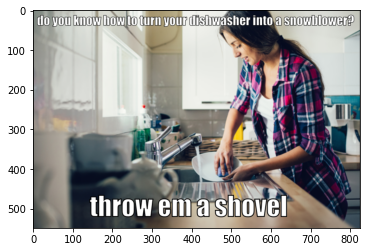

In [18]:
img = load_img(sample_filename)
print(img.shape)
plt.imshow(img)

### 2.1.2 Get Image Segments

In [19]:
def get_features(sample):
    feature_dir = "/opt/datasets/mmf/datasets/hateful_memes/defaults/features/clean"
    
    return {
        "features": os.path.join(feature_dir, f"{sample:05}.npy"),
        "features_info": os.path.join(feature_dir, f"{sample:05}_info.npy")
    }

In [20]:
feature_fps = get_features(sample)
img_gradients = load_npy(fps['img_gradient'], True)

img_features = np.load(feature_fps['features'], allow_pickle=True)
img_info = np.load(feature_fps['features_info'], allow_pickle=True).item()

In [21]:
assert img.shape[0] == img_info['image_height']
assert img.shape[1] == img_info['image_width']
assert img_features.shape == img_gradients.shape

In [22]:
print(img_features.shape, img_gradients.shape)
img_info.keys()

(100, 2048) (100, 2048)


dict_keys(['image_id', 'bbox', 'num_boxes', 'image_height', 'image_width', 'objects', 'cls_prob'])

In [23]:
def sort_image_gradients(gradients):
    # Take the average across all dimensions
    gradients = gradients.mean(axis=1)
    
    # Sort the img gradients by the magnitude of the attribution scores
    indices = sorted(range(len(gradients)), key=lambda i: gradients[i], reverse=True)
    
    return indices

top_k_indices = sort_image_gradients(img_gradients)
top_k_indices[:9]

[52, 53, 64, 8, 26, 27, 13, 40, 11]

In [24]:
print("image coverage @ 9:", img_gradients[top_k_indices][:9].sum() / img_gradients.sum())
print("image coverage @ 10:", img_gradients[top_k_indices][:10].sum() / img_gradients.sum())
print("image coverage @ 20:", img_gradients[top_k_indices][:20].sum() / img_gradients.sum())

image coverage @ 9: 0.35065153
image coverage @ 10: 0.3749535
image coverage @ 20: 0.5814498


In [25]:
img_info['bbox'][top_k_indices[:9]]

array([[460.48987  ,   1.2681059, 634.5048   , 147.85918  ],
       [484.2353   ,   0.       , 640.58606  , 211.51236  ],
       [424.23602  ,   0.       , 833.7937   , 407.79413  ],
       [459.10675  ,  37.04575  , 735.6064   , 516.7367   ],
       [523.05554  ,  84.759895 , 833.7937   , 498.0796   ],
       [185.4502   ,  12.495098 , 759.78296  , 503.97983  ],
       [478.86322  ,  23.196037 , 738.7273   , 166.38702  ],
       [512.2378   ,  74.97714  , 659.3622   , 372.0372   ],
       [371.09027  ,   0.       , 652.2887   , 436.2324   ]],
      dtype=float32)

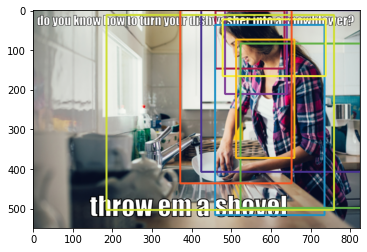

In [26]:
def draw_bboxes(img, bounding_boxes: list):
    image = img.copy()
    for idx, (box, color) in enumerate(zip(bounding_boxes, colors)):
        top_left, bottom_right = box[:2].astype(int), box[2:].astype(int)
        image = cv2.rectangle(image, tuple(top_left), tuple(bottom_right), tuple(color), 3)
    
    return image
        
image = draw_bboxes(img, img_info['bbox'][top_k_indices[:9]])
plt.imshow(image)

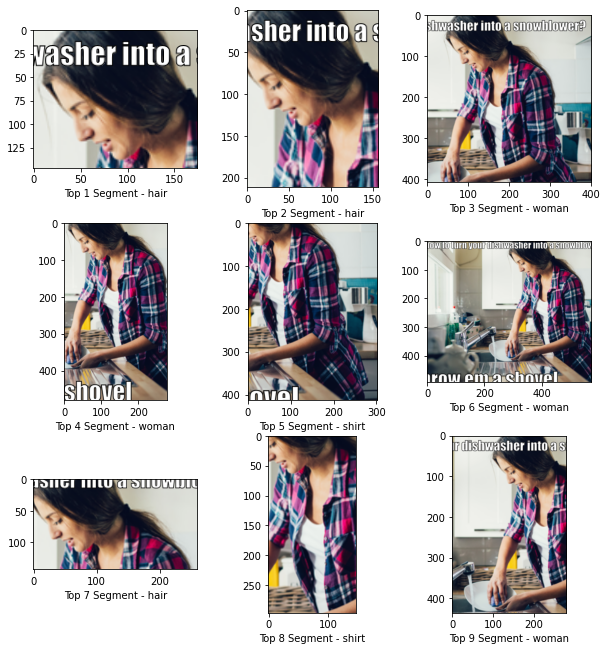

In [27]:
def crop_img_segments(image, indices):        
    fig = plt.figure(figsize=(10, 15))
    
    segments = []
    for (xmin, ymin, xmax, ymax), cat in zip(img_info['bbox'], img_info['objects']):
        xmin, ymin = round(xmin), round(ymin)
        xmax, ymax = round(xmax), round(ymax)

        segments.append((image[ymin:ymax, xmin:xmax], categories_dict[cat]))

    for idx, i in enumerate(indices):
        segment_i, segment_cls = segments[i]

        if len(segment_i) == 0:
            segment_i = np.array([[0]])
            segment_cls += "(out of bounds)"

        ax = fig.add_subplot(4, 3, idx+1)
        ax.imshow(segment_i)
        ax.set_xlabel('Top {} Segment - {}'.format(idx + 1, segment_cls))
        
crop_img_segments(img, top_k_indices[:9])

## 2.2 Examine Textual Data

In [28]:
sample = 7528
fps = get_filepaths("visual_bert_coco", sample)

In [29]:
text_gradients, metadata = load_npy(fps['text_gradients']), load_json(fps['text_metadata'])
text_gradients.shape

(1, 128, 768)

In [30]:
metadata

{'pred_probs': 0.9691146612167358,
 'pred_class': 'Hateful',
 'true_class': 'Hateful',
 'attr_class': 'Hateful',
 'raw_input': ['[CLS]',
  'the',
  'latest',
  'and',
  'greatest',
  '.',
  'a',
  'truck',
  'that',
  'comes',
  'with',
  'a',
  'dish',
  '##wash',
  '##er',
  '!',
  '[SEP]'],
 'convergence_score': 0.009316821876360848}

In [31]:
def visualise_texts(gradients, metadata):
    gradients = process_attribution(gradients)
    gradients = gradients[:len(metadata['raw_input'])]
    
    return [visualization.VisualizationDataRecord(
        gradients,
        metadata['pred_probs'],
        metadata['pred_class'],
        metadata['true_class'],
        metadata['attr_class'],
        gradients.sum(),
        metadata['raw_input'],
        metadata['convergence_score'])
    ]

In [32]:
print('Visualize attributions based on Integrated Gradients')
records = visualise_texts(text_gradients, metadata)
_ = visualization.visualize_text(records)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Hateful,Hateful (0.97),Hateful,1.51,[CLS] the latest and greatest . a truck that comes with a dish ##wash ##er ! [SEP]


# 3. Truncated Version (For Easier Visualisation and Exploration)

### 3.1.1 Load sample information

In [35]:
sample = 46518
sample_filename = f"{sample:05}.png"

fps = get_filepaths("visual_bert_coco", sample)
feature_fps = get_features(sample)

### 3.1.2 Prepare image gradients

In [36]:
img = load_img(sample_filename)

In [37]:
img_gradients = load_npy(fps['img_gradient'], True)
img_features = np.load(feature_fps['features'], allow_pickle=True)
img_info = np.load(feature_fps['features_info'], allow_pickle=True).item()

img_bboxes = img_info['bbox']

In [38]:
assert img.shape[0] == img_info['image_height']
assert img.shape[1] == img_info['image_width']
assert img_features.shape == img_gradients.shape

In [39]:
top_k_indices = sort_image_gradients(img_gradients)

### 3.1.4 Visualise and explore

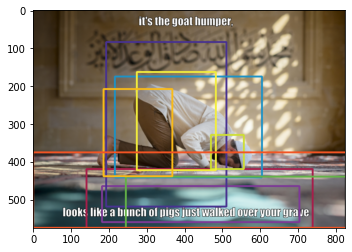

In [40]:
images_bb = draw_bboxes(img, img_bboxes[top_k_indices[:9]])
plt.imshow(images_bb)

### 3.1.3 Visualise Text

In [41]:
text_gradients, metadata = load_npy(fps['text_gradients']), load_json(fps['text_metadata'])

In [42]:
print('Visualize attributions based on Integrated Gradients')
records = visualise_texts(text_gradients, metadata)
_ = visualization.visualize_text(records)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Hateful,Not Hateful (0.71),Hateful,0.95,"[CLS] it ' s the goat hum ##per , looks like a bunch of pigs just walked over your grave [SEP]"
